In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/code/uchicago/sociohydro/sim/meanField/SchellingMF`
Precompiling project...
  ✓ SchellingMF
  1 dependency successfully precompiled in 2 seconds. 207 already precompiled.


In [2]:
using SchellingMF
using Distributions
using LaTeXStrings
using JSON
using LinearAlgebra
using BenchmarkTools
using HDF5
using Printf
using PyPlot
using ProgressMeter

# Fisher waves

$$\partial_t \phi = D \nabla^2 \phi + r \phi (1 - \phi)$$

In [3]:
lap(Nx::Int64, dx::Float64) = diagm(-(Nx - 1) => [1],
                                  -1 => 1 * ones(Nx - 1),
                                  0 => -2 * ones(Nx),
                                  +1 => 1 * ones(Nx - 1),
                                  +(Nx - 1) => [1]) ./ dx^2

function growth(ϕ::Array{T, 1}, r::T) where T<:AbstractFloat
    return r .* ϕ .* (1 .- ϕ)
end

function diff(ϕ::Array{T, 1}, Δ::Array{T, 2}, D::T) where T<:AbstractFloat
    # preallocation
    DΔϕ = similar(ϕ)
    
    # get diffusion
    mul!(DΔϕ, Δ, ϕ, D, 0)
    
    return DΔϕ
end

function update!(ϕ::Array{T, 1}, Δ::Array{T, 2}, dt::T, r::T, D::T) where T<:AbstractFloat
    f = growth(ϕ, r)
    DΔϕ = diff(ϕ, Δ, D)
    
    # update
    ϕ += dt * (DΔϕ + f)
    
    return ϕ
end

function run_sim(L::T, dx::T, t_final::T, dt::T, r::T, D::T) where T<:AbstractFloat
    x_array = collect(-L/2:dx:L/2)
    t_array = collect(0.0:dt:t_final)
    Nx = length(x_array)
    Nt = length(t_array)
    
    # laplacian operator
    Δ = lap(Nx, dx)
    
    ϕ_array = zeros(Nx, (Nt ÷ 10))
    
    sigma = 3
    ϕ = @. 0.5.*(1 .- tanh.(2 * (x_array .+ L/4)))
    ϕ_array[:, 1] = ϕ
    
    @showprogress for (ii, t) in enumerate(t_array)
        ϕ = update!(ϕ, Δ, dt, r, D)
        ϕ[1] = 1
        ϕ[end] = 0
        
        if mod(ii, 10) == 0
            ϕ_array[:, (ii ÷ 10)] = ϕ
        end
    end
    
    return ϕ_array, x_array, t_array
end

run_sim (generic function with 1 method)

In [4]:
L = 100.0
dx = 0.1
t_final = 100.0
dt = 0.4 * dx^2
D = 1.0
r = 0.5

ϕ, x, t = run_sim(L, dx, t_final, dt, r, D)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


([1.0 1.0 … 1.0 1.0; 1.0 1.0 … 0.9999999999999983 0.9999999999999983; … ; 0.0 0.0 … 0.04080781204294046 0.040807812047910334; 0.0 0.0 … 0.0 0.0], [-50.0, -49.9, -49.8, -49.7, -49.6, -49.5, -49.4, -49.3, -49.2, -49.1  …  49.1, 49.2, 49.3, 49.4, 49.5, 49.6, 49.7, 49.8, 49.9, 50.0], [0.0, 0.004000000000000001, 0.008000000000000002, 0.012000000000000004, 0.016000000000000004, 0.020000000000000004, 0.024000000000000007, 0.028000000000000008, 0.03200000000000001, 0.03600000000000001  …  99.96000000000002, 99.96400000000003, 99.96800000000002, 99.97200000000002, 99.97600000000003, 99.98000000000002, 99.98400000000002, 99.98800000000003, 99.99200000000002, 99.99600000000002])

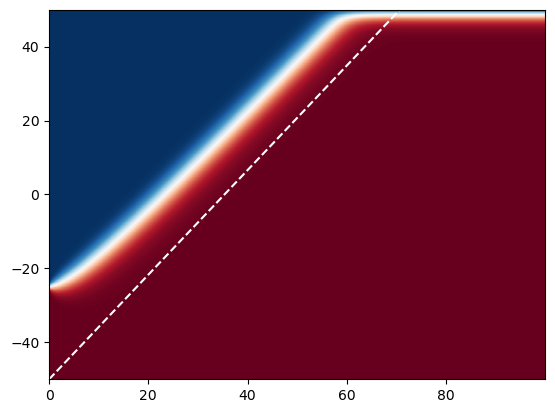

2-element Vector{Tuple{Float64, Float64}}:
 (-50.0, 50.0)
 (0.0, 99.99600000000002)

In [5]:
fig, ax = plt.subplots()
ax.pcolormesh(t[1:10:end], x, ϕ,
              cmap="RdBu_r", vmin=0, vmax=1)
ax.plot(t, t * (2*sqrt(r * D)) .+ minimum(x), "w--")
ax.set(ylim=[minimum(x), maximum(x)],
       xlim=[minimum(t), maximum(t)])

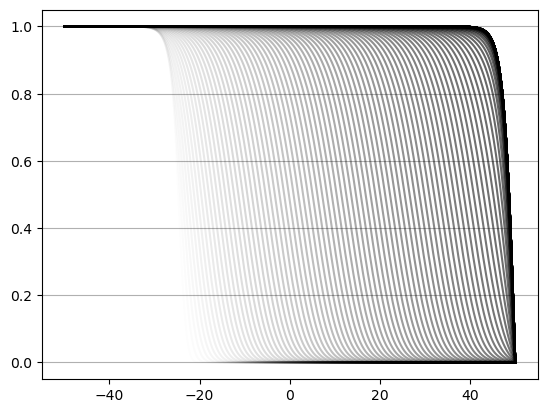

In [6]:
fig, ax = plt.subplots()
for ii in 1:20:length(ϕ[1, :])
    ax.plot(x, ϕ[:, ii], "k", alpha=ii/length(ϕ[1, :]))
end
ax.grid(axis="y")

# SchellingMF with growth

In [3]:
function load_data(savepath)
    # load data
    files = readdir(savepath, join=true)
    params = JSON.parsefile(files[end])
    N_saved = length(files) - 1

    ϕA_array = Array{Float64}(undef, params["Nx"], N_saved)
    ϕB_array = Array{Float64}(undef, params["Nx"], N_saved)
    x_array = Array{Float64}(undef, params["Nx"])
    t_array = Array{Float64}(undef, N_saved)
    for (fidx, file) in enumerate(files[1:end-1])
        h5open(file, "r") do d
            ϕA_array[:, fidx] = read(d["data"], "phiA")
            ϕB_array[:, fidx] = read(d["data"], "phiB")
            t_array[fidx] = read(d["data"], "t")
            if fidx == 1
                x_array[:] = read(d["data"], "x")
            end
        end
    end
    return ϕA_array, ϕB_array, x_array, t_array, params
end

load_data (generic function with 1 method)

First we make sure the code actually runs

In [4]:
dx = 0.625
Nx = 96
dt = 1e-2
Nt = Int(1e5)
snapshot = 10000
savepath = "/Users/danny/Google Drive/My Drive/uchicago/adaptation/schelling/2023-10-17_schellingGrowthTest"
ϕA0 = 1/4
ϕB0 = 1/4
δϕA0 = 0.05
δϕB0 = 0.05
α = 0.0
δ = +0.5
κ = 0.1
Tc = (1 + α) * ϕA0
temp = 0.1
Γ = 1.0

ϕA, ϕB, t = run_simulation(dx, Nx, dt, Nt, snapshot, savepath,
                           ϕA0=ϕA0, ϕB0=ϕB0, δϕA0=δϕA0, δϕB0=δϕB0,
                           α=α, δ=δ, κ=κ, temp=temp, Γ=Γ)

Starting main loop...


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


([2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322  …  2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322], [2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322  …  2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322, 2.4e-322], 999.9999999992356)

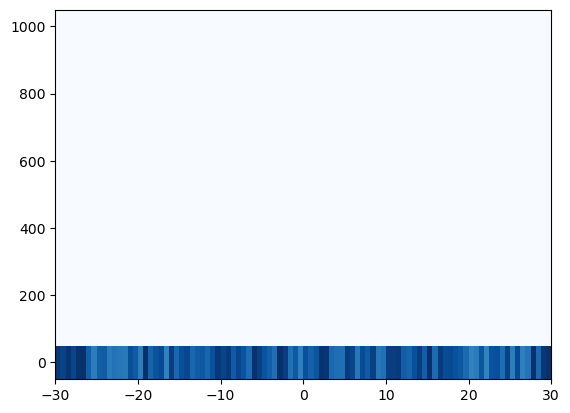

PyObject <matplotlib.collections.QuadMesh object at 0x1622a9ba0>

In [5]:
ϕA, ϕB, x, t, params = load_data(savepath)
fig, ax = plt.subplots()
ax.pcolormesh(x, t, Transpose(ϕA), cmap="Blues")

Now, the system should reduce to Fisher waves with one species, a constant fitness, and $\Gamma = 0$, so we get rid of the bilaplacian

In [3]:
dx = 0.625
Nx = 256
dt = 1e-2
Nt = Int(2e4)
snapshot = 100
savepath = "/Users/danny/Google Drive/My Drive/uchicago/sociohydro/2023-10-17_schellingGrowthTest"
# ϕA0 = 1/4
# ϕB0 = 1/4
α = 0.0
δ = 0.0
κ = 0.0
temp = 0.5
Γ = 0.0

# start with a nice initial condition
L = dx * Nx
x_array = collect(-L/2:dx:L/2-dx)
ϕA0 = @. 0.5*(tanh(x_array + L/50) - tanh(x_array - L/50))
ϕB0 = zeros(length(ϕA0))
t_init = 0.0

ϕA, ϕB, t = run_simulation(ϕA0, ϕB0, t_init,
                           dx, Nx, dt, Nt, snapshot, savepath,
                           α=α, δ=δ, κ=κ, temp=temp, Γ=Γ)

Starting main loop...


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


([0.9840842525344348, 0.9849054514287284, 0.9870820176966166, 0.9899370240689755, 0.9927789270860281, 0.9951647671014752, 0.9969415214330133, 0.9981523792819378, 0.9989240252151989, 0.9993912316605413  …  0.9996632544803815, 0.9993912316605413, 0.9989240252151989, 0.9981523792819378, 0.9969415214330132, 0.9951647671014752, 0.9927789270860281, 0.9899370240689757, 0.9870820176966166, 0.9849054514287284], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 199.99999999996308)

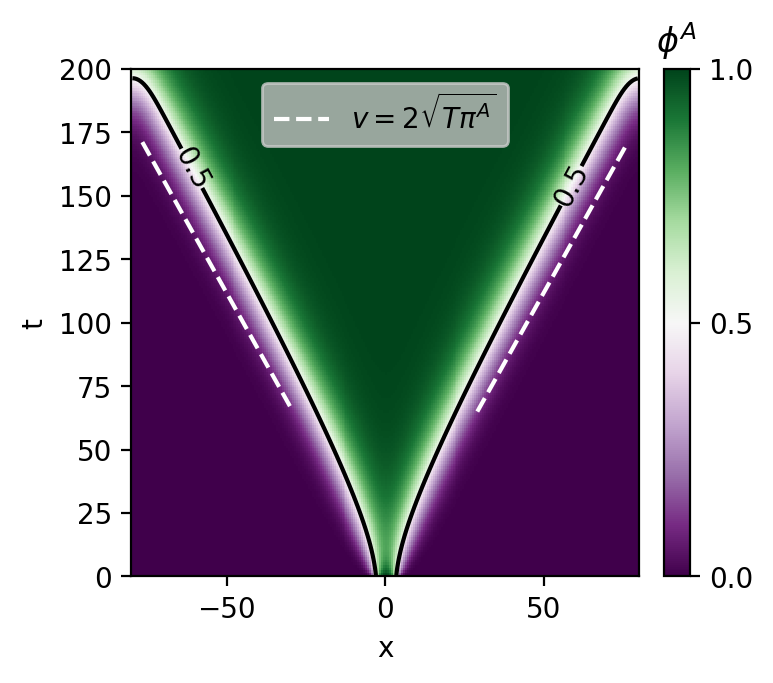

In [139]:
v = 2 * sqrt(temp * 0.1)

ϕA, ϕB, x, t, params = load_data(savepath)
fig, ax = plt.subplots(dpi=200, figsize=(4, 4))
c = ax.contour(x, t, Transpose(ϕA),
           levels=[0.5], cmap="Greys_r")
ax.clabel(c, c.levels, inline=true, fontsize=10)
a = ax.pcolormesh(x, t, Transpose(ϕA),
                  cmap="PRGn", vmin=0, vmax=1,
                  rasterized=true)
cax = ax.inset_axes([1.05, 0, 0.05, 1])
cbar = fig.colorbar(a, ax=ax, cax=cax, ticks=[0, 0.5, 1])
cbar.ax.set(title=L"\phi^A")
ax.plot(x[175:250], +x[175:250] / v, "w--")
ax.plot(x[6:81], -x[6:81] / v, "w--", label=L"v = 2\sqrt{T \pi^A}")
ax.legend(loc="upper center", facecolor="0.75")
ax.set(ylim=[0, maximum(t)],
       xlabel="x", ylabel="t")
ax.set_box_aspect(1)
plt.tight_layout()
# fig.savefig("/Users/danny/Google Drive/My Drive/uchicago/sociohydro/2023-10-17_schellingGrowthTest_fisher.pdf")

Now we introduce the linear fitness functions
$$\pi^a(\vec{\phi}) = g^a + \kappa^{ab} \phi^b$$
where $g^a$ is an intrinsic growth

In [18]:
dx = 0.625
Nx = 256
dt = 1e-2
Nt = Int(1e5)
snapshot = 100
savepath = "/Users/danny/Google Drive/My Drive/uchicago/sociohydro/2023-10-17_schellingGrowthTest"
ϕA0 = 1/4
ϕB0 = 1/4
α = 0.0
δ = 0.1
κ = 0.0
temp = 0.5
Γ = 1.0

# start with a nice initial condition
L = dx * Nx
x_array = collect(-L/2:dx:L/2-dx)
ϕA0 = @. 0.5*(tanh(x_array + L/50 - L/10) - tanh(x_array - L/50 - L/10))
ϕB0 = @. 0.5*(tanh(x_array + L/50 + L/10) - tanh(x_array - L/50 + L/10))
t_init = 0.0

# predetermined initial condition
ϕA, ϕB, t = run_simulation(ϕA0, ϕB0, t_init,
                           dx, Nx, dt, Nt, snapshot, savepath,
                           α=α, δ=δ, κ=κ, temp=temp, Γ=Γ)
# random initial condition
# ϕA, ϕB, t = run_simulation(dx, Nx, dt, Nt, snapshot, savepath,
#                            α=α, δ=δ, κ=κ, temp=temp, Γ=Γ,
#                            ϕA0=ϕA0, ϕB0=ϕB0)

Starting main loop...


Progress:  49%|████████████████████                     |  ETA: 0:00:21

LoadError: OverflowError: got nans

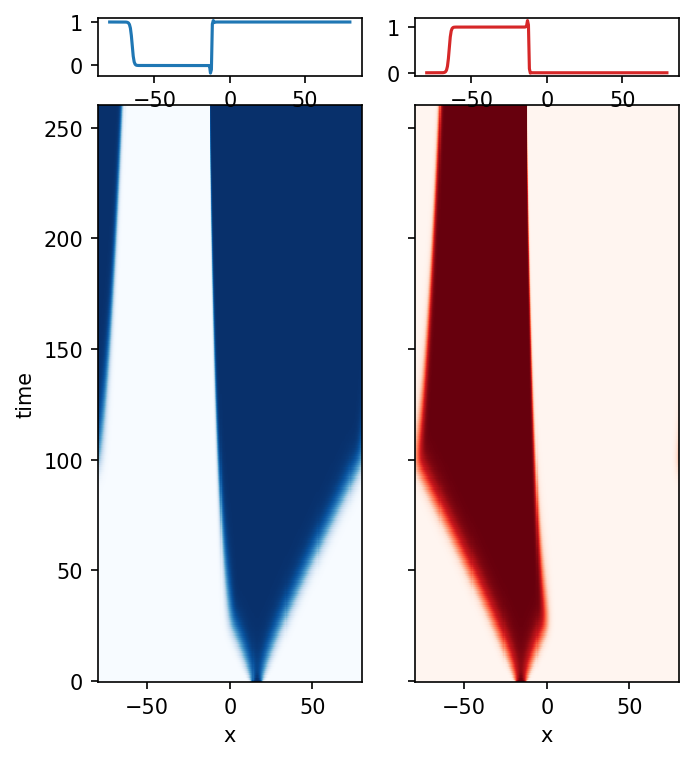

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15f02d150>

In [13]:
ϕA, ϕB, x, t, params = load_data(savepath)

fig, ax = plt.subplots(1, 2, dpi=150, figsize=(5, 5),
                       sharey=true)
ax[1].pcolormesh(x, t, Transpose(ϕA),
              cmap="Blues", vmin=0, vmax=1)
ax1end=ax[1].inset_axes([0, 1.05, 1, 0.1])
ax[1].set(xlabel="x", ylabel="time")
ax1end.plot(x, ϕA[:, end], color="C0")
# ax1end.set(ylim=[0, 1])

ax[2].pcolormesh(x, t, Transpose(ϕB),
                 cmap="Reds", vmin=0, vmax=1)
ax2end=ax[2].inset_axes([0, 1.05, 1, 0.1])
ax[2].set(xlabel="x")
ax2end.plot(x, ϕB[:, end], color="C3")
# ax2end.set(ylim=[0, 1])


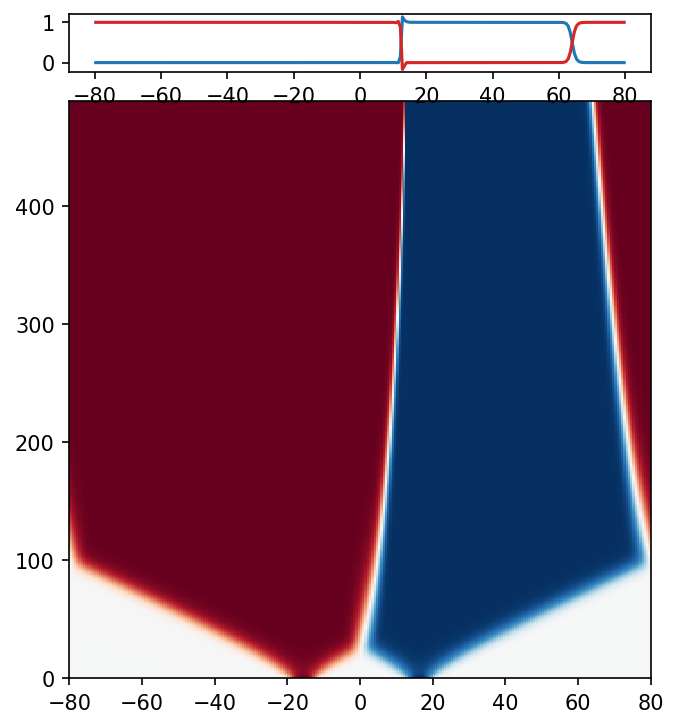

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15ee5e710>

In [19]:
ϕA, ϕB, x, t, params = load_data(savepath)

fig, ax = plt.subplots(dpi=150, figsize=(5, 5))
ax.pcolormesh(x, t, Transpose(ϕA - ϕB),
              cmap="RdBu", vmin=-1, vmax=1)
axend = ax.inset_axes([0, 1.05, 1, 0.1])
axend.plot(x, ϕA[:, end], color="C0")
axend.plot(x, ϕB[:, end], color="C3")

In [42]:
dx = 0.625
Nx = 256
dt = 1e-2
Nt = Int(1e5)
snapshot = 100
savepath = "/Users/danny/Google Drive/My Drive/uchicago/sociohydro/2023-10-17_schellingGrowthTest"
ϕA0 = 1/4
ϕB0 = 1/4
α = 0.0
δ = 2.0
κ = 0.0
temp = 0.5
Γ = 1.0

# start with a nice initial condition
L = dx * Nx
x_array = collect(-L/2:dx:L/2-dx)
# ϕA0 = @. 0.5*(tanh(x_array + L/50 - L/4) - tanh(x_array - L/50 - L/4))
# ϕB0 = @. 0.5*(tanh(x_array + L/50 + L/4) - tanh(x_array - L/50 + L/4))
t_init = 0.0

# predetermined initial condition
ϕA, ϕB, t = run_simulation(ϕA[:, end], ϕB[:, end], 1000.0,
                           dx, Nx, dt, Nt, snapshot, savepath,
                           α=α, δ=δ, κ=κ, temp=temp, Γ=Γ)
# random initial condition
# ϕA, ϕB, t = run_simulation(dx, Nx, dt, Nt, snapshot, savepath,
#                            α=α, δ=δ, κ=κ, temp=temp, Γ=Γ,
#                            ϕA0=ϕA0, ϕB0=ϕB0)

Starting main loop...


Progress:  50%|████████████████████▋                    |  ETA: 0:00:08

LoadError: InterruptException:

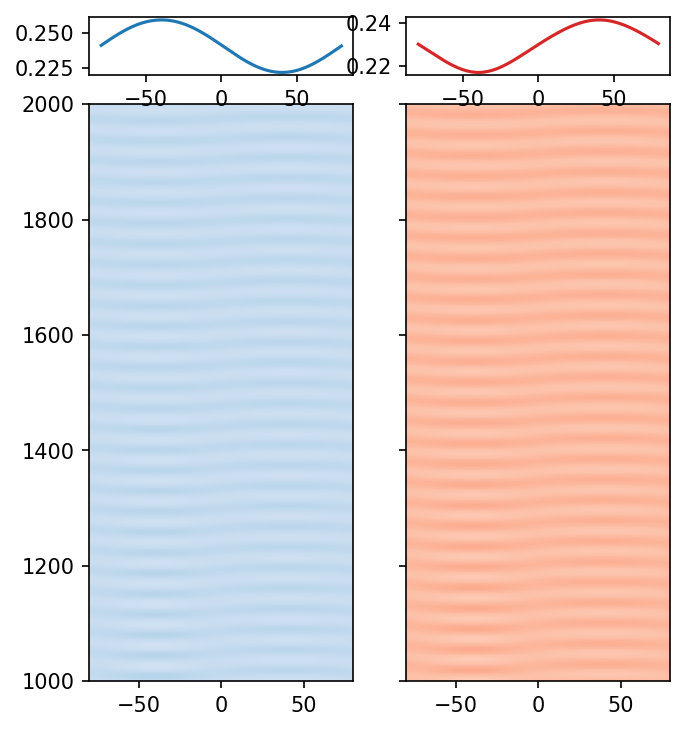

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2984b21d0>

In [41]:
ϕA, ϕB, x, t, params = load_data(savepath)

fig, ax = plt.subplots(1, 2, dpi=150, figsize=(5, 5),
                       sharey=true)
ax[1].pcolormesh(x, t, Transpose(ϕA),
              cmap="Blues", vmin=0, vmax=1)
ax1end=ax[1].inset_axes([0, 1.05, 1, 0.1])
ax1end.plot(x, ϕA[:, end], color="C0")
# ax1end.set(ylim=[0, 1])

ax[2].pcolormesh(x, t, Transpose(ϕB),
                 cmap="Reds", vmin=0, vmax=1)
ax2end=ax[2].inset_axes([0, 1.05, 1, 0.1])
ax2end.plot(x, ϕB[:, end], color="C3")
# ax2end.set(ylim=[0, 1])
